In [4]:
### 🔧 TAREA
# Compara el desempeño de la red neuronal con la regresión logística. Analiza sus métricas, curva ROC y precisión vs. recall.

In [1]:
import sys
sys.path.append("../src")

import train
import model
import utils
import evaluate as ev

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

In [2]:
# 🔧 Cargar configuración
config = train.load_config("../config.yaml")

In [3]:
# 📦 Cargar y preparar los datos
X, y = train.load_data("../data/credit_clean_wo_outliers.csv")
X_train, X_test, y_train, y_test = train.preprocess(X, y, config)

In [4]:
# 🧪 Entrenar modelo base (Regresión Logística)
base_model = LogisticRegression(max_iter=1000)
base_model.fit(X_train, y_train)

# 🔍 Predicciones del modelo base
y_pred_log = base_model.predict(X_test)
y_proba_log = base_model.predict_proba(X_test)[:, 1]

In [5]:
# 📥 Cargar modelo entrenado Red Neuronal
from tensorflow.keras.models import load_model
nn_model = load_model("../models/nn_model-drop.keras")

# 🔍 Predicciones de Red Neuronal
y_proba_nn = nn_model.predict(X_test).flatten()
y_pred_nn = ev.predict_with_threshold(y_proba_nn, threshold=0.5)

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [12]:
# 📊 Evaluación individual
eva_logistica = ev.evaluate_model(y_test, y_pred_log, y_proba_log, model_name="Regresión Logística")
eva_red = ev.evaluate_model(y_test, y_pred_nn, y_proba_nn, model_name="Red Neuronal")


📊 Evaluación del modelo: Regresión Logística
              precision    recall  f1-score   support

           0       0.73      0.77      0.75      2875
           1       0.73      0.69      0.71      2605

    accuracy                           0.73      5480
   macro avg       0.73      0.73      0.73      5480
weighted avg       0.73      0.73      0.73      5480

F1 Score     : 0.7121
Precision    : 0.7311
Recall       : 0.6940
ROC AUC      : 0.8040

📊 Evaluación del modelo: Red Neuronal
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      2875
           1       0.79      0.70      0.75      2605

    accuracy                           0.77      5480
   macro avg       0.77      0.77      0.77      5480
weighted avg       0.77      0.77      0.77      5480

F1 Score     : 0.7461
Precision    : 0.7930
Recall       : 0.7044
ROC AUC      : 0.8487


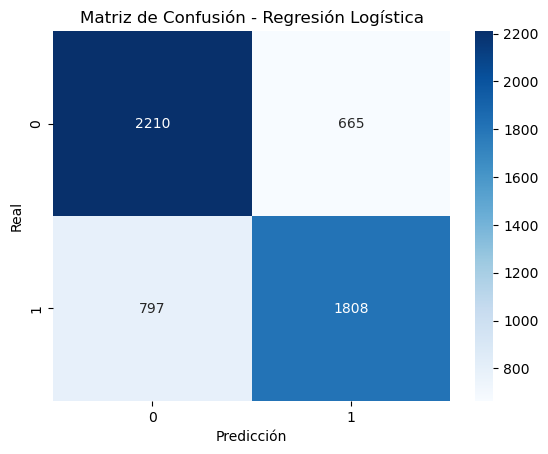

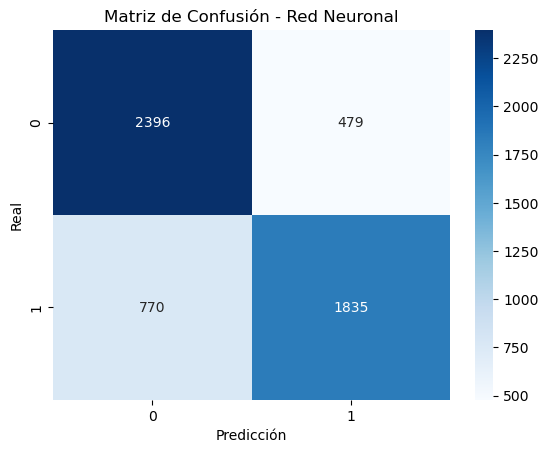

In [7]:
# 🧱 Matrices de Confusión
ev.plot_confusion_matrix(y_test, y_pred_log, model_name="Regresión Logística")
ev.plot_confusion_matrix(y_test, y_pred_nn, model_name="Red Neuronal")

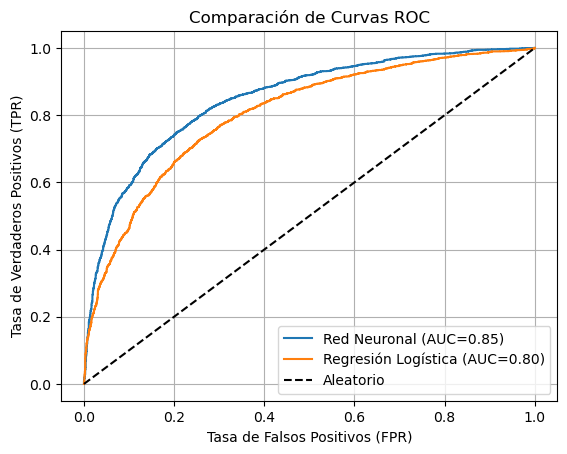

In [8]:
# 📈 Comparación de curvas ROC
ev.plot_roc_comparison(y_test, y_proba_nn, y_test, y_proba_log,
                       label1="Red Neuronal", label2="Regresión Logística")

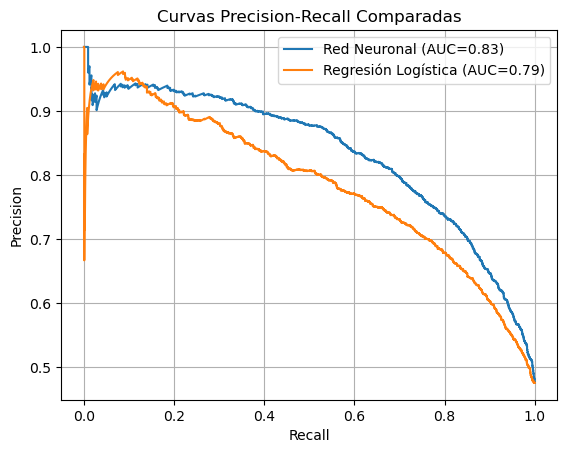

In [9]:
# 🔍 Comparación de curvas Precision-Recall
ev.plot_precision_recall_curves(y_test, y_proba_nn, y_test, y_proba_log,
                                 label1="Red Neuronal", label2="Regresión Logística")

In [10]:
# 📋 Comparación de métricas en tabla
df_metrics = ev.compare_models_metrics(
    y_test, y_pred_nn, y_proba_nn,
    y_test, y_pred_log, y_proba_log,
    model_name_1="Red Neuronal",
    model_name_2="Regresión Logística"
)

import IPython.display as display
display.display(df_metrics)

,Modelo,Precision,Recall,F1-score,ROC AUC
0,Red Neuronal,0.792999,0.704415,0.746087,0.848715
1,Regresión Logística,0.731096,0.694050,0.712091,0.804000


In [ ]:
### 📊 Pregunta de reflexión
#¿En qué umbral se maximiza el F1-score para cada modelo? ¿Te parece razonable utilizar 0.5 como punto de corte en este contexto?


In [ ]:
# Funcion para encontrar el umbral óptimo basado en F1-score
def encontrar_umbral_optimo(y_true, y_proba):
    umbrales = np.linspace(0.0, 1.0, 200)
    f1_scores = []
    precisiones = []
    recalls = []

    for umbral in umbrales:
        y_pred = (y_proba >= umbral).astype(int)
        f1_scores.append(f1_score(y_true, y_pred))
        precisiones.append(precision_score(y_true, y_pred))
        recalls.append(recall_score(y_true, y_pred))

    # Encontrar el umbral que maximiza el F1
    mejor_idx = np.argmax(f1_scores)
    umbral_optimo = umbrales[mejor_idx]

    print(f"🧠 Umbral óptimo: {umbral_optimo:.3f}")
    print(f"F1-score máximo: {f1_scores[mejor_idx]:.4f}")
    print(f"Precisión: {precisiones[mejor_idx]:.4f}")
    print(f"Recall: {recalls[mejor_idx]:.4f}")

    # Gráfico opcional
    plt.plot(umbrales, f1_scores, label="F1-score")
    plt.plot(umbrales, precisiones, label="Precisión")
    plt.plot(umbrales, recalls, label="Recall")
    plt.axvline(x=umbral_optimo, color='r', linestyle='--', label=f"Umbral óptimo = {umbral_optimo:.2f}")
    plt.xlabel("Umbral de decisión")
    plt.ylabel("Score")
    plt.title("F1 / Precisión / Recall vs Umbral")
    plt.legend()
    plt.grid(True)
    plt.show()

    return umbral_optimo

🧠 Umbral óptimo: 0.367
F1-score máximo: 0.7705
Precisión: 0.7279
Recall: 0.8184


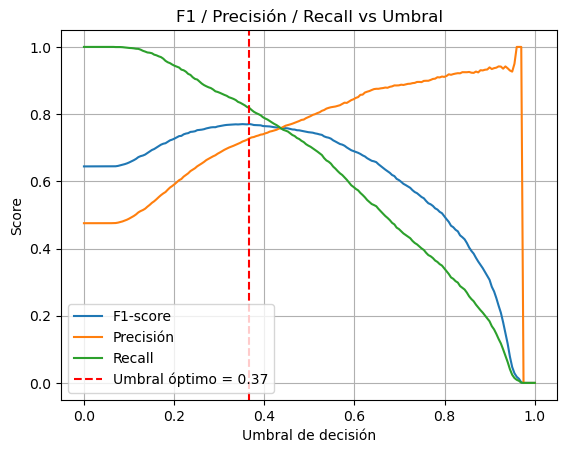

In [25]:
import warnings
warnings.filterwarnings("ignore")

umbral_optimo_nn = encontrar_umbral_optimo(y_test, y_proba_nn)


🧠 Umbral óptimo: 0.362
F1-score máximo: 0.7352
Precisión: 0.6694
Recall: 0.8154


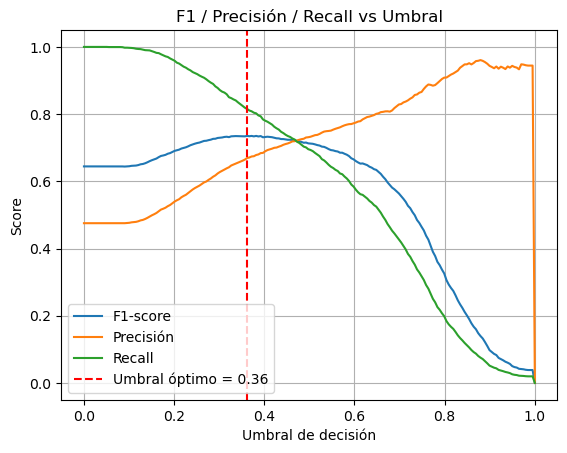

In [26]:
umbral_optimo_log = encontrar_umbral_optimo(y_test, y_proba_log)

**¿En qué umbral se maximiza el F1-score para cada modelo? ¿Te parece razonable utilizar 0.5 como punto de corte en este contexto?**

Ambos modelos tiene su umbral que maximiza el f1-score en 0.36, pero al revisar los scores con ese punto de corte, no sube mucho el f1-score (aprox en 0.02)

**¿Es uno de los modelos más conservador o arriesgado que el otro?**

La regresion logistica tiene un menor recall y F1, lo que indicaria que el modelo predice menos positivos *en general*. No se arriesga tanto a decir que una clase es 1... Aunque en nuestro ejercicio, la regresion logistica predijo mas 1, resultando mayores falsos positivos 

In [ ]:
#¿Es uno de los modelos más conservador o arriesgado que el otro?